In [1]:
import numpy as np
## for data
import pandas as pd
import collections
import json
import string 
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for text processing
import re
import nltk
from nltk.tokenize import word_tokenize
## for sentiment
from textblob import TextBlob
## for ner, pos
import spacy
nlp = spacy.load("en_core_web_lg")
nltk.download('wordnet')
## parameters searching
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
## rmse
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator

import dill as pickle

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/annazhukovets/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import os
import logging
# a function  to create and save logs in the log files
def log(path, file):
    """[Create a log file to record the experiment's logs]
    
    Arguments:
        path {string} -- path to the directory
        file {string} -- file name
    
    Returns:
        [obj] -- [logger that record logs]
    """

    # check if the file exist
    log_file = os.path.join(path, file)

    if not os.path.isfile(log_file):
        open(log_file, "w+").close()

    console_logging_format = "%(levelname)s %(message)s"
    file_logging_format = "%(levelname)s: %(asctime)s: %(message)s"

    # configure logger
    logging.basicConfig(level=logging.INFO, format=console_logging_format)
    logger = logging.getLogger()
    
    # create a file handler for output file
    handler = logging.FileHandler(log_file)

    # set the logging level for log file
    handler.setLevel(logging.INFO)
    
    # create a logging format
    formatter = logging.Formatter(file_logging_format)
    handler.setFormatter(formatter)

    # add the handlers to the logger
    logger.addHandler(handler)

    return logger

In [3]:
# X
with open('pickles/X.pk', 'rb') as data:
    X = pickle.load(data)

# y
with open('pickles/y.pk', 'rb') as data:
    y = pickle.load(data)

In [4]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer

class regressor_stratified_cv:
    def __init__(self, n_splits = 10, n_repeats = 2, group_count = 10,
                 random_state = 0, strategy = 'quantile'):
        self.group_count = group_count
        self.strategy = strategy
        self.cvkwargs = dict(n_splits = n_splits, n_repeats = n_repeats, 
                             random_state = random_state)
        self.cv = RepeatedStratifiedKFold(**self.cvkwargs)
        self.discretizer = KBinsDiscretizer(n_bins = self.group_count, encode = 'ordinal',
                                            strategy = self.strategy)  
            
    def split(self, X, y, groups = None):
        kgroups=self.discretizer.fit_transform(y[:, None])[:, 0]
        return self.cv.split(X, kgroups, groups)
    
    def get_n_splits(self, X, y, groups = None):
        return self.cv.get_n_splits(X, y, groups)

In [5]:
# n_splits = 5
# n_repeats = 2
# group_count = 10
# cv = regressor_stratified_cv(n_splits = n_splits, n_repeats = n_repeats,
#                            group_count = group_count, random_state = 0, strategy = 'quantile')

# for train_index, test_index in cv.split(X, y):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y[train_index], y[test_index]

In [6]:
# from matplotlib import pyplot


# pyplot.hist(y_train, bins = 10, alpha=0.5, label='train')
# pyplot.hist(y_test, bins = 10, alpha=0.5, label='test');

In [7]:
# define the class IDFVectorizer
# to generate new feature with mean of idf
class IDFVectorizer(BaseEstimator):

    def __init__(self):
        pass

    def fit(self, x_dataset, y=None):
        return self

    def transform(self, x_dataset):
        
        # removal of punctuation
        PUNCT_TO_REMOVE = string.punctuation
        def remove_punctuation(text):
            return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
        
        # removal of stopwords
        from nltk.corpus import stopwords
        ", ".join(stopwords.words('english'))
        STOPWORDS = set(stopwords.words('english'))
        def remove_stopwords(text):
            return " ".join([word for word in str(text).split() if word not in STOPWORDS])
        
        # lemmatization 
        from nltk.stem import WordNetLemmatizer
        lemmatizer = WordNetLemmatizer()
        def lemmatize_words(text):
            return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
        
        # word frequency in docs
        def doc_freq(word):
            c = 0
            try:
                c = DF[word]
            except:
                pass
            return c
        
        # idf vector generation
        def mean_of_vector(tokens):
            idf_vec = []
            for token in np.unique(tokens):
                df = doc_freq(token)
                idf = np.log(N/(df + 1))
                try:
                    idf_vec.append(idf)
                except:
                    pass
            
            return np.mean(idf_vec)
        
        # lower casing
        x_dataset["excerpt_proc"] = x_dataset["excerpt"].str.lower()
        # removal of punctuation
        x_dataset["excerpt_proc"] = x_dataset["excerpt_proc"].apply(lambda text: remove_punctuation(text))
        # removal of stopwords
#         x_dataset["excerpt_proc"] = x_dataset["excerpt_proc"].apply(lambda text: remove_stopwords(text))
        # lemmatization 
        x_dataset["excerpt_proc"] = x_dataset["excerpt_proc"].apply(lambda text: lemmatize_words(text))    
        # tokenizetion
        x_dataset["excerpt_proc"] = x_dataset["excerpt_proc"].apply(lambda x: [token for token in word_tokenize(x)])
        
        N = len(x_dataset["excerpt"])
        DF = {}
        for i in range(N):
            tokens = x_dataset["excerpt_proc"].iloc[i]
            for w in tokens:
                try:
                    DF[w].add(i)
                except:
                    DF[w] = {i}
            

        for i in DF:
            DF[i] = len(DF[i]) 

        x_dataset['idf_vec'] = x_dataset["excerpt_proc"].apply(lambda x:  mean_of_vector(x))
        
        return x_dataset

In [8]:
logger = log(path="logs/", file="logs.csv")

In [9]:
# pre-processsing step
# Drop the columns 
from sklearn.compose import ColumnTransformer
pre_process = ColumnTransformer(remainder='passthrough',
                                transformers=[('drop_columns', 'drop', ['id', 
                                                                        'url_legal', 
                                                                        'license',
                                                                        'excerpt',
                                                                        'standard_error',
                                                                        'ner_tags',
                                                                        'pos_tags',
                                                                        'excerpt_proc',
                                                                        'nlp_text'
                                                                       ])])

In [10]:
pipe = Pipeline([#('get_new_columns', FeatureGenerator()),
                 ('idf_vect', IDFVectorizer()),
                 ('pre_processing',pre_process),
                 ('random_forest', RandomForestRegressor(bootstrap = True, max_depth = 50, 
                                                         max_features = 'auto', min_samples_leaf = 4, 
                                                         min_samples_split = 10, n_estimators = 800))
                ])

In [11]:
n_splits = 5
n_repeats = 2
group_count = 10
cv = regressor_stratified_cv(n_splits = n_splits, n_repeats = n_repeats,
                           group_count = group_count, random_state = 0, strategy = 'quantile')


logger.info("Train RF with stopwords")
i = 0
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    pipe.fit(X_train, y_train)
    predict = pipe.predict(X_test)
    rmse = mean_squared_error(y_test, predict, squared=False)
    logger.info("The rmse for RF iteration {}: {:.3f}".format(i, rmse))
    logger.info("-------------------------------")
    i += 1

INFO Train RF with stopwords
INFO The rmse for RF iteration 0: 0.823
INFO -------------------------------
INFO The rmse for RF iteration 1: 0.836
INFO -------------------------------
INFO The rmse for RF iteration 2: 0.792
INFO -------------------------------
INFO The rmse for RF iteration 3: 0.782
INFO -------------------------------
INFO The rmse for RF iteration 4: 0.832
INFO -------------------------------
INFO The rmse for RF iteration 5: 0.817
INFO -------------------------------
INFO The rmse for RF iteration 6: 0.820
INFO -------------------------------
INFO The rmse for RF iteration 7: 0.793
INFO -------------------------------
INFO The rmse for RF iteration 8: 0.811
INFO -------------------------------
INFO The rmse for RF iteration 9: 0.826
INFO -------------------------------


Feature: 0, Score: 0.02088
Feature: 1, Score: 0.02848
Feature: 2, Score: 0.00618
Feature: 3, Score: 0.02018
Feature: 4, Score: 0.08416
Feature: 5, Score: 0.01921
Feature: 6, Score: 0.00077
Feature: 7, Score: 0.00010
Feature: 8, Score: 0.00591
Feature: 9, Score: 0.00146
Feature: 10, Score: 0.00500
Feature: 11, Score: 0.00223
Feature: 12, Score: 0.00434
Feature: 13, Score: 0.00012
Feature: 14, Score: 0.00023
Feature: 15, Score: 0.00007
Feature: 16, Score: 0.00184
Feature: 17, Score: 0.00004
Feature: 18, Score: 0.00164
Feature: 19, Score: 0.00363
Feature: 20, Score: 0.00001
Feature: 21, Score: 0.00032
Feature: 22, Score: 0.00877
Feature: 23, Score: 0.00660
Feature: 24, Score: 0.01329
Feature: 25, Score: 0.00316
Feature: 26, Score: 0.00696
Feature: 27, Score: 0.01008
Feature: 28, Score: 0.00006
Feature: 29, Score: 0.01450
Feature: 30, Score: 0.00879
Feature: 31, Score: 0.00475
Feature: 32, Score: 0.01095
Feature: 33, Score: 0.00585
Feature: 34, Score: 0.00125
Feature: 35, Score: 0.01379
Fe

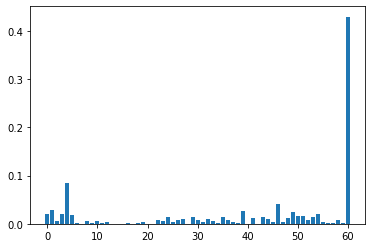

In [16]:
# get importance
importance = pipe.steps[2][1].feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [18]:
# # n_estimators
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# # max_features
# max_features = ['auto', 'sqrt']

# # max_depth
# max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
# max_depth.append(None)

# # min_samples_split
# min_samples_split = [2, 5, 10]

# # min_samples_leaf
# min_samples_leaf = [1, 2, 4]

# # bootstrap
# bootstrap = [True, False]

# # Create the random grid
# random_grid = {'random_forest__n_estimators': n_estimators,
#                'random_forest__max_features': max_features,
#                'random_forest__max_depth': max_depth,
#                'random_forest__min_samples_split': min_samples_split,
#                'random_forest__min_samples_leaf': min_samples_leaf,
#                'random_forest__bootstrap': bootstrap}

# random_search = RandomizedSearchCV(estimator=pipe,
#                                    param_distributions=random_grid,
#                                    n_iter=5,
#                                    scoring='neg_mean_absolute_error',
#                                    cv=3, 
#                                    verbose=1, 
#                                    random_state=8)

In [19]:
# random_search.fit(X, y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  3.7min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('idf_vect', IDFVectorizer()),
                                             ('pre_processing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('drop_columns',
                                                                               'drop',
                                                                               ['id',
                                                                                'url_legal',
                                                                                'license',
                                                                                'excerpt',
                                                                                'standard_error',
                                                                                'ner_tags',
             

In [20]:
# print("The best hyperparameters from Random Search are:")
# print(random_search.best_params_)
# print("")
# print("The mean accuracy of a model with these hyperparameters is:")
# print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'random_forest__n_estimators': 800, 'random_forest__min_samples_split': 10, 'random_forest__min_samples_leaf': 4, 'random_forest__max_features': 'auto', 'random_forest__max_depth': 40, 'random_forest__bootstrap': True}

The mean accuracy of a model with these hyperparameters is:
-0.674254618935198


In [21]:
# # n_estimators
# n_estimators = [800]

# # max_features
# max_features = ['auto']

# # max_depth
# max_depth = [30, 40, 50]

# # min_samples_split
# min_samples_split = [10, 20]

# # min_samples_leaf
# min_samples_leaf = [4, 6]

# # bootstrap
# bootstrap = [True]

# # Create the random grid
# parameters = {'random_forest__n_estimators': n_estimators,
#                'random_forest__max_features': max_features,
#                'random_forest__max_depth': max_depth,
#                'random_forest__min_samples_split': min_samples_split,
#                'random_forest__min_samples_leaf': min_samples_leaf,
#                'random_forest__bootstrap': bootstrap}

In [22]:
# grid = GridSearchCV(pipe, param_grid=parameters, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=1)

In [23]:
# grid.fit(X, y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 39.3min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('idf_vect', IDFVectorizer()),
                                       ('pre_processing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop_columns',
                                                                         'drop',
                                                                         ['id',
                                                                          'url_legal',
                                                                          'license',
                                                                          'excerpt',
                                                                          'standard_error',
                                                                          'ner_tags',
                                                                          'pos_tags',

In [24]:
# print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'random_forest__bootstrap': True, 'random_forest__max_depth': 50, 'random_forest__max_features': 'auto', 'random_forest__min_samples_leaf': 4, 'random_forest__min_samples_split': 10, 'random_forest__n_estimators': 800}


In [ ]:
# # n_estimators
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# # max_features
# max_features = ['auto', 'sqrt']

# # max_depth
# max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
# max_depth.append(None)

# # min_samples_split
# min_samples_split = [2, 5, 10]

# # min_samples_leaf
# min_samples_leaf = [1, 2, 4]

# # bootstrap
# bootstrap = [True, False]

# # Create the random grid
# random_grid = {'rrandom_forest__n_estimators': n_estimators,
#                'random_forest__max_features': max_features,
#                'random_forest__max_depth': max_depth,
#                'random_forest__min_samples_split': min_samples_split,
#                'random_forest__min_samples_leaf': min_samples_leaf,
#                'random_forest__bootstrap': bootstrap}

# random_search = RandomizedSearchCV(estimator=pipe,
#                                    param_distributions=random_grid,
#                                    n_iter=5,
#                                    scoring='neg_root_mean_squared_error',
#                                    cv=3, 
#                                    verbose=1, 
#                                    random_state=8)